# Modelling crystallisation in magmatic systems
**JAR625M 2024 - Week 10 - Practical 2**

Simon Matthews (simonm@hi.is)

---

In this practical you will apply thermodynamic models of magma and crystals to predict the chemical evolution of magmas during cooling and crystallisation.

The volcano Hekla is at the margin of Iceland's Eastern Volcanic Zone ([see it on the geological map](https://arcgisserver.isor.is/?lon=-19.72399&lat=63.97042&zoom=12&_ga=2.98804317.2103429531.1682513440-734776706.1680257934&_gl=1*8rzm79*_ga*Njk1NTI2Njg0LjE3MDQzMDI3NDA.*_ga_SYHREZS7XD*MTcwNjAxNTgzNy40LjEuMTcwNjAxNTg4NC4wLjAuMA..&layers%5B%5D=satellite&layers%5B%5D=geology&layers%5B%5D=names&layers%5B%5D=highTemperatureBoreholes)). The last time Hekla erupted was in 2000, but prior to that it had erupted approximately every 10 years. Notably, lava compositions from basalt to rhyolite have been erupted, but the origin of this compositional diversity is debated. One model proposes that the silicic melts are produced by melting of hydrothermally altered crust [(e.g., Sigmarsson et al., 2022)](https://doi.org/10.1007/s00410-021-01883-5), with compositionally intermediate melts formed by mixing between the mafic (mantle derived) basaltic melt and this silicic crustal melt. Alternatively, it is suggested that the entire compositional suite can be formed by fractional crystallisation of basaltic melt [(e.g., Geist et al., 2021)](http://www.doi.org/10.1093/petrology/egab001).

In this practical you will use thermodynamic modelling to assess whether fractional crystallisation is a viable model for explaining the diversity in magma compositions.

---

First, import the python packages required:

In [1]:
import numpy as np
import pandas as pd
import magmaforge
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

`Magmaforge` is a python library for running thermodynamic calculations for modelling magmatic systems, and will make our task much easier.

## Part 1: Import data and plot magma compositions

A table of whole rock compositions from Hekla is contained in the csv file `hekla.csv`, which we can import:

In [2]:
hekla_data = pd.read_csv('hekla.csv')
hekla_data['FeOT'] = hekla_data['FeOt']
hekla_data.head()

Sample  SiO2  TiO2  Al2O3  FeOt   MnO   MgO   CaO  Na2O   K2O  ...    Rb  \
0   H5-A  72.7  0.15   12.8  2.20  0.08  0.13  1.68  4.77  2.56  ...  60.5   
1   H4-5  72.0  0.14   12.6  2.12  0.09  0.07  1.44  4.79  2.71  ...  62.0   
2   H4-7  72.6  0.15   13.3  2.19  0.09  0.09  1.29  5.00  2.96  ...   NaN   
3   H4-3  66.3  0.52   14.8  7.43  0.25  0.37  3.53  5.16  2.08  ...   NaN   
4     H2  68.6  0.29   14.0  3.98  0.12  0.30  2.49  5.03  2.18  ...   NaN   

      Sr    Co   Ni   Sc    Nb      Zr    Yb                      Ref.  FeOT  
0  123.0   9.0  7.0  7.0  72.5   276.0  86.3  Schuessler et al. (2009)  2.20  
1  107.0   5.0  5.0  4.0  84.5   329.0  96.8  Schuessler et al. (2009)  2.12  
2    NaN   NaN  NaN  NaN   NaN     NaN   NaN  Schuessler et al. (2009)  2.19  
3    NaN   NaN  NaN  NaN   NaN  1160.0   NaN  Schuessler et al. (2009)  7.43  
4  188.0  19.0  NaN  9.0   NaN     NaN   NaN  Schuessler et al. (2009)  3.98  

[5 rows x 24 columns]

We can make some Harker plots to visualise the variation in the composition of the samples:

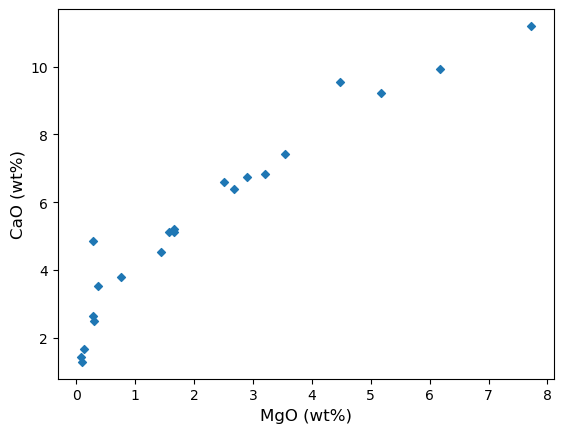

In [3]:
fig, ax = plt.subplots()

ax.scatter(hekla_data['MgO'], hekla_data['CaO'])

ax.set_xlabel('MgO (wt%)')
ax.set_ylabel('CaO (wt%)')

plt.show()

### Q1.1: Using the code above as an example, make some more Harker plots with at least 3 other major element oxides

In [4]:
# Your code here...

In [5]:
# Your code here...

In [6]:
# Your code here...

### Q1.2: Summarise the variability in the major elements. How might this be consistent with crystal fractionation or mixing with silicic crustal melts?

*Your answer here...*

## Part 2: Set up the thermodynamic calculation

Before we can begin to model the crystallisation of the magma we need to choose a composition to start with. This should be our best guess at what the most primitive melt in the system is. The sample with highest MgO will be a good starting point. In this context primitive means the magma that has undergone least crystallisation.

### Q2.1 Why is the sample with the highest MgO likely to be the most primitive?

*Your answer here...*

We can extract the row of the table that corresponds to the most primitive composition:

In [7]:
most_primitive = hekla_data.loc[hekla_data.MgO.argmax()]
most_primitive

Sample                       Hek-4
SiO2                          46.0
TiO2                          2.37
Al2O3                         16.0
FeOt                          13.0
MnO                            0.2
MgO                           7.73
CaO                           11.2
Na2O                          2.42
K2O                            0.4
H2O                           0.14
Total                         99.5
Th                            1.08
Ba                           109.0
Rb                             8.2
Sr                           372.0
Co                            51.0
Ni                           114.0
Sc                            33.0
Nb                            19.9
Zr                           141.0
Yb                            24.7
Ref.      Schuessler et al. (2009)
FeOT                          13.0
Name: 20, dtype: object

Now we can extract the oxide components and adjust the H$_2$O content to account for the lava having lost most of its H$_2$O to volcanic degassing:

In [15]:
comp={
      'SiO2': most_primitive.SiO2,
      'TiO2': most_primitive.TiO2,
      'Al2O3': most_primitive.Al2O3,
      'Fe2O3': 0.0
      'FeO':  most_primitive.FeOt,
      'MgO':  most_primitive.MgO,
      'CaO':  most_primitive.CaO,
      'Na2O': most_primitive.Na2O,
      'K2O':  most_primitive.K2O,
      'P2O5':  0.0,
      'H2O':  1.0, # You might want to try adjusting this later!
      }

We need to tell `magmaforge` what temperature to start the calculations at (in degrees Kelvin). A temperature of 1300˚C should be comfortably above the liquidus of the rock composition we have chosen:

In [16]:
T0=1300 + 273.15

## Part 3: Do some calculations!

Now we need to set up a `magmaforge` system. We will start with a system at 6 kbar, which would correspond to a very deep magma chamber:

In [17]:
sys = magmaforge.System(comp=comp, P=6000.0, T0=T0, model_name="v1.2",
                        O2_buffer='NNO', del_fO2=0)

Now we will run a crystallisation calculation. If the calculation runs for longer than 1 minute it is likely the algorithm has got stuck. Press stop and continue with the results calculated up to that point.

In [18]:
sys.crystallize(method='equil', fix_fO2=True, Tstep=2)

Liquid is the omnicomponent phase.
kc Fe3+/Fe2+ input grams Fe2O3, FeO 4.999139148843946 8.501721188048588
kc Fe3+/Fe2+ comp  grams Fe2O3, FeO 2.3602940062033246 10.87618310486375
******************************** 
Calculating saturation state for Feldspar
Affinity, mole fraction -4184.813641976661 [0.19793782 0.80008704 0.00197515]
 
******************************** 
Calculating saturation state for Quartz
Affinity, mole fraction 7121.536405557417 [1.]
 
******************************** 
Calculating saturation state for Spinel
Affinity, mole fraction -2345.277623894829 [0.         0.11492535 0.11963853 0.73969256 0.02574356]
 
******************************** 
Calculating saturation state for Orthopyroxene
Affinity, mole fraction -4575.200601839065 [-0.33193203  0.89361115  0.34163122  0.06860467 -0.05563588  0.08073422
  0.00298665]
 
******************************** 
Calculating saturation state for Water
Affinity, mole fraction 29545.637195851712 [1.]
 
*****************************

/opt/conda/lib/python3.10/site-packages/magmaforge/system.py:334: UserWarning: Warning: Unsuccessful cooling step ended equilibrium calculation.
  warnings.warn("Warning: Unsuccessful cooling step ended equilibrium calculation.")


We can visualise the model results:

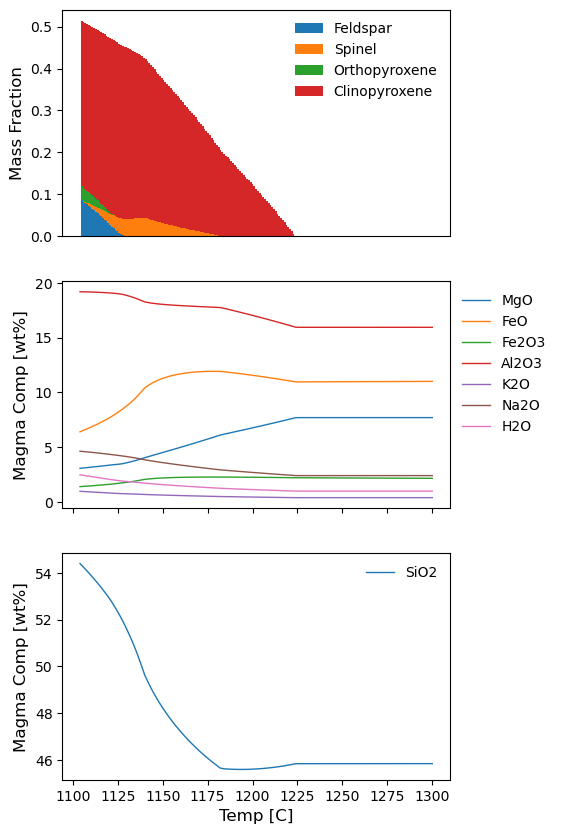

In [19]:
magmaforge.plot.magma_evolution(sys.history)

This isn't particularly helpful in identifying whether we have modelled the suite of data from Hekla. A better way to plot this up is to use a ternary plot:

2024-03-11 10:30:31,752 pyrolite.mineral.normative - WARNING: Required columns missing: Fe2O3, FeO


2024-03-11 10:30:32,021 pyrolite.mineral.normative - WARNING: Required columns missing: Fe2O3, FeO


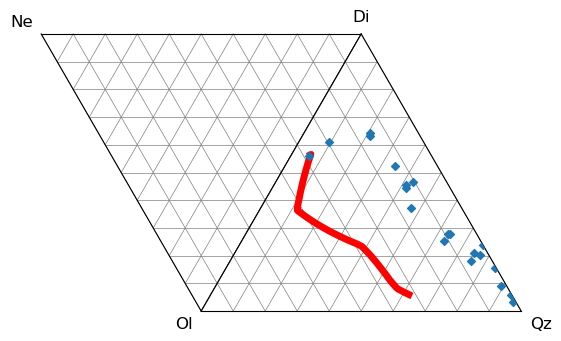

In [33]:
fig = plt.figure()
ax = magmaforge.plot.TernaryPlotAxes(fig)

# Plot the model result
tbl = sys.history.liquid_comp_table
tbl['FeOT'] = tbl['FeO'] + tbl['Fe2O3'] / (55.845 + 1.5*15.999) * (55.845 + 15.999)
ax.plot(magmaforge.plot.ternaryEndmembersFromCIPW(tbl, calcFeSpeciation=True)[0], lw=5, c='r')

# Plot the Hekla Data
ax.scatter(magmaforge.plot.ternaryEndmembersFromCIPW(hekla_data, calcFeSpeciation=True)[0], zorder=10)

Crystallisation at these conditions does not match the data well. Something to think about- why does the model path suddenly change direction?

Now try changing the pressure the crystallisation is happening at, and re-make the plots. What pressure works best?